In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import seaborn as sn
import pandas as pd
from tqdm import tqdm

In [48]:
batch_size = 512
epochs = 20
learning_rate = 1e-3

In [49]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

##Getting training set
train_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=True, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

##Getting test set
test_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=False, transform=transform, download=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [50]:
latent_vector = 16
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
        
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=256)
        self.enc3 = nn.Linear(in_features=256, out_features=128)
        self.enc4 = nn.Linear(in_features=128, out_features=latent_vector*2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=latent_vector, out_features=128)
        self.dec2 = nn.Linear(in_features=128, out_features=256)
        self.dec3 = nn.Linear(in_features=256, out_features=512)
        self.dec4 = nn.Linear(in_features=512, out_features=784)
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x, encode = True):
        if encode:
            x = torch.relu(self.enc1(x))
            x = torch.relu(self.enc2(x))
            x = torch.relu(self.enc3(x))
            x = self.enc4(x).view(-1, 2, latent_vector)
        
            # get `mu` and `log_var`
            mu = x[:, 0, :] # the first feature values as mean
            log_var = x[:, 1, :] # the other feature values as variance
            
            
        else:
            #if only decoding needs to be done, then x is given as a list [mu, logvar]
            mu = x[0]
            log_var = x[1]
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = torch.relu(self.dec1(z))
        x = torch.relu(self.dec2(x))
        x = torch.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')#nn.MSELoss()

In [52]:
def final_loss(bce_loss, mu, logvar):
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [53]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    
    for i, data in enumerate(dataloader):
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [54]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            data, _ = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
            
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [55]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, test_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 20
Train Loss: 225.8101
Val Loss: 197.4468
Epoch 2 of 20
Train Loss: 190.8593
Val Loss: 182.8570
Epoch 3 of 20
Train Loss: 174.7147
Val Loss: 166.0723
Epoch 4 of 20
Train Loss: 157.7526
Val Loss: 151.5013
Epoch 5 of 20
Train Loss: 144.8642
Val Loss: 139.6996
Epoch 6 of 20
Train Loss: 136.8598
Val Loss: 134.9018
Epoch 7 of 20
Train Loss: 132.0158
Val Loss: 129.2868
Epoch 8 of 20
Train Loss: 127.9168
Val Loss: 127.3132
Epoch 9 of 20
Train Loss: 125.4244
Val Loss: 124.2060
Epoch 10 of 20
Train Loss: 123.3749
Val Loss: 122.6661
Epoch 11 of 20
Train Loss: 121.9166
Val Loss: 121.7767
Epoch 12 of 20
Train Loss: 120.6989
Val Loss: 120.3485
Epoch 13 of 20
Train Loss: 119.6310
Val Loss: 121.7727
Epoch 14 of 20
Train Loss: 118.7969
Val Loss: 118.7875
Epoch 15 of 20
Train Loss: 117.9182
Val Loss: 118.1438
Epoch 16 of 20
Train Loss: 117.1708
Val Loss: 117.6831
Epoch 17 of 20
Train Loss: 116.4747
Val Loss: 116.7241
Epoch 18 of 20
Train Loss: 115.8218
Val Loss: 116.4202
Epoch 19 of 20
Trai

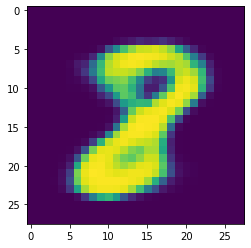

In [78]:
mu = torch.tensor(np.array([1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0])).float()
logvar = torch.tensor(np.array([0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0])).float()
#logvar = torch.tensor(np.zeros((1, latent_vector))).float()
representation = [mu, logvar]
with torch.no_grad():
    reconstruction,_, _ = model.forward(representation, encode=False)
    plt.imshow(reconstruction.numpy().reshape(28, 28))